In [1]:
import json, glob, re, pycm, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from IPython.display import display, Markdown

In [2]:
EXPERIMENT_RUN_VERSION = "v9"
DATASET_SIZE = 1000.

In [3]:
def display_cms(cms):
    fig = plt.figure(figsize=(20,14))
    gs = fig.add_gridspec(4, 5, hspace=0.5)
    axes = gs.subplots()
    for ax, (name, cm) in zip(axes.flat, cms):
        df = pd.DataFrame(cm.matrix).T.fillna(0)
        sns.heatmap(df, annot=True, fmt='d', cmap="YlGnBu", ax=ax)
        ax.set_title(name, wrap=True, fontsize=9)
        ax.set(xlabel='Predicted', ylabel='Actual')
    for ax in axes.flat[len(cms):]:
        ax.set_visible(False)
    plt.show()

In [4]:
models = {}
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/unilateral/*.json"):
    model = re.match(r'.*/unilateral/(.*)-simpleqa.json', file).group(1)
    if model not in models:
        models[model] = {}
    df = pd.DataFrame.from_records(json.load(open(file, "r"))).query('evaluation == "t" or evaluation == "f"')
    models[model]["unilateral"] = pycm.ConfusionMatrix(df["label"].tolist(), df["evaluation"].tolist(), digit=2, classes=[ 't', 'f' ])
for file in glob.glob(f"experiments/{EXPERIMENT_RUN_VERSION}/bilateral/*.json"):
    model = re.match(r'.*/bilateral/(.*)-simpleqa.json', file).group(1)
    if model not in models:
        models[model] = {}
    df = pd.DataFrame.from_records(json.load(open(file, "r"))).query('evaluation == "t" or evaluation == "f"')
    models[model]["bilateral"] = pycm.ConfusionMatrix(df["label"].tolist(), df["evaluation"].tolist(), digit=2, classes=[ 't', 'f' ])

## Mistral-7B-Instruct-v0.3

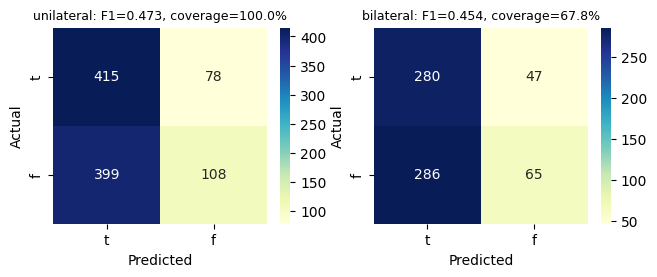

## Mixtral-8x7B-Instruct-v0.1

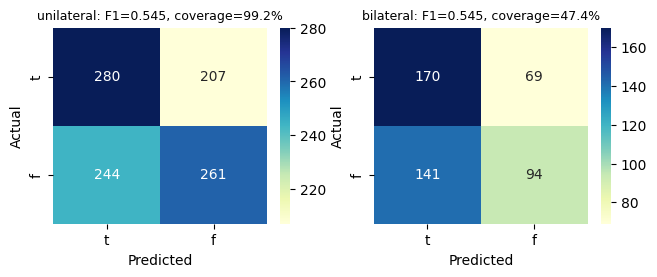

## gpt-4o-2024-11-20

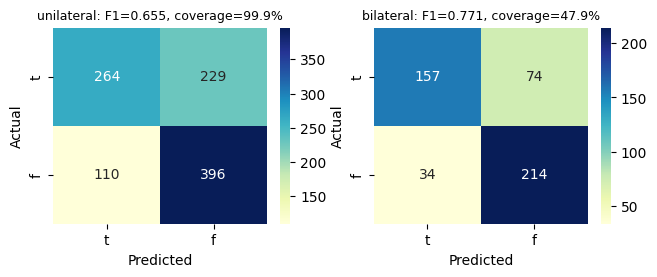

## gpt-4o-mini

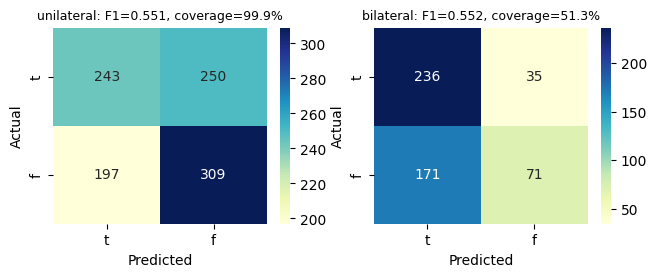

In [6]:
for model in models:
    display(Markdown(f'## {model}'))
    display_cms([
        (f"unilateral: F1={models[model]['unilateral'].F1_Macro:0.3f}, coverage={float(sum(models[model]['unilateral'].N.values()))/float(DATASET_SIZE):0.1%}", 
         models[model]["unilateral"]), 
        (f"bilateral: F1={models[model]['bilateral'].F1_Macro:0.3f}, coverage={float(sum(models[model]['bilateral'].N.values()))/float(DATASET_SIZE):0.1%}", 
         models[model]["bilateral"])])